# 卷积神经网络（LeNet）
LeNet（LeNet-5）由两个部分组成： 卷积编码器和全连接层密集块

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self,x):
        # 自动计算 批量数不变 x channel:1 x 28 x28
        return x.view(-1,1,28,28)


net = torch.nn.Sequential(  #input :1x28x28的image
                            Reshape(),
                            #input channel:1 
                            #output channel:6
                            # padding:2
                            # input: 32x32
                            nn.Conv2d(1,6,kernel_size=5,padding=2),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=2,stride=2),
                            # input channel:6
                            # output channel :16
                            nn.Conv2d(6,16,kernel_size=5),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=2,stride=2),
                            #第一个批量维度保持住，其他维度拉平
                            nn.Flatten(),
                            nn.Linear(16*5*5,120),
                            nn.ReLU(),
                            nn.Linear(120,84),
                            nn.ReLU(),
                            nn.Linear(84,10)    

)

检查模型

In [8]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


LeNet在Fashion-MNIST数据集上的表现

In [9]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对 evaluate_accuracy函数进行轻微的修改

In [10]:
# def evaluate_accuracy_gpu(net,data_iter,device=None):
#     """使用GPU计算模型在数据集上的精度。"""
#     if isinstance(net,torch.nn.Module):
#         net.eval()
#         # 如果不知道device，把net的第一个参数的device拿出来，看看在哪里
#         if not device:
#             device = next(iter(net.parameters())).device()
#     metric = d2l.Accumulator(2)
#     for X,y in data_iter:
#         #把X,y移到net 参数所在的device
#         if isinstance(X,list):
#             X = [x.to(device) for x in X]
#         else:
#             X = X.to(device)
#         y = y.to(device)
#         metric.add(d2l.accuracy(net(X),y),y.numel())
#     return metric[0]/metric[1]
    
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用 GPU，我们还需要一点小改动

In [11]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    #w的初始化，使output的方差都相同
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    # 打印一下 device
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 每个批量移入cpu
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

loss 0.224, train acc 0.915, test acc 0.884
19498.5 examples/sec on cuda:0


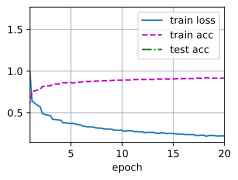

In [19]:
lr, num_epochs = 0.3, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())